In [3]:
!pip install "numpy<2.0"

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

<h2>Solving a 1D Heat Equation</h2>

<h3>d_u/d_t = a * d_uu/d_xx</h3>

<h4>
    where, <br>
    u(x, t) = Temperature at length 'x' and at time 't'<br><br>
    t = Time<br><br>
    x = Length of 1D rod(say)
</h4>

In [8]:
class NN(nn.Module):

    def __init__(self):
        super(NN, self).__init__()
        self.seq = nn.Sequential(
            nn.Linear(2, 64),
            nn.Tanh(),
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1),
            nn.Tanh()
        )

    def forward(self, x, t):

        data = torch.cat([x, t], dim = 1)
        return self.seq(data)

In [204]:
class PINN:

    def __init__(self):

        self.alpha = 0.1
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        self.model = NN()
        self.model.to(self.device)
        self.generate_values()
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = 0.001)

    def generate_values(self):
        
        self.x_ic = torch.linspace(0, 1, 1000).view(-1, 1).to(self.device)
        self.t_ic = torch.zeros_like(self.x_ic).to(self.device)
        self.u_ic = torch.sin(torch.pi * self.x_ic).to(self.device)

        self.t_bc = torch.linspace(0, 1, 1000).view(-1, 1).to(self.device)
        self.x_bc0 = torch.zeros_like(self.t_bc).to(self.device)
        self.u_bc0 = torch.zeros_like(self.t_bc).to(self.device)
        self.x_bc1 = torch.ones_like(self.t_bc).to(self.device)
        self.u_bc1 = torch.zeros_like(self.t_bc).to(self.device)

        self.x = torch.rand(1000).view(-1, 1).to(self.device)
        self.x.requires_grad = True
        self.t = torch.rand(1000).view(-1, 1).to(self.device)
        self.t.requires_grad = True


    
    def calc_pde_loss(self):

        u = self.model(self.x, self.t)

        u_x = torch.autograd.grad(u, self.x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_t = torch.autograd.grad(u, self.t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, self.x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]

        return torch.mean((u_t - self.alpha * u_xx) ** 2)


    def train(self, epochs = 1000):
        self.model.train()
        self.epoch_loss = []
        self.ic_loss = []
        self.bc_loss = []
        self.pde_loss = []
        for epoch in range(epochs):
            self.optimizer.zero_grad()

            u_ic_pred = self.model(self.x_ic, self.t_ic)
            loss_ic = torch.mean((self.u_ic - u_ic_pred) ** 2)

            u_bc0_pred = self.model(self.x_bc0, self.t_bc)
            u_bc1_pred = self.model(self.x_bc1, self.t_bc)
            loss_bc = torch.mean((self.u_bc0 - u_bc0_pred) ** 2) + torch.mean((self.u_bc1 - u_bc1_pred) ** 2)

            loss_pde = self.calc_pde_loss()

            loss = loss_ic + loss_bc + loss_pde
            
            self.ic_loss.append(loss_ic.item())
            self.bc_loss.append(loss_bc.item())
            self.pde_loss.append(loss_pde.item())
            self.epoch_loss.append(loss.item())

            loss.backward()
            self.optimizer.step()
            if epoch%100 == 0:
                print(f"Epoch : {epoch}\nloss_ic : {loss_ic}\nloss_bc : {loss_bc}\npde_loss : {loss_pde}")

        def generate_values(self):
        
        self.x_ic = torch.linspace(0, 1, 1000).view(-1, 1).to(self.device)
        self.t_ic = torch.zeros_like(self.x_ic).to(self.device)
        self.u_ic = torch.sin(torch.pi * self.x_ic).to(self.device)

        self.t_bc = torch.linspace(0, 1, 1000).view(-1, 1).to(self.device)
        self.x_bc0 = torch.zeros_like(self.t_bc).to(self.device)
        self.u_bc0 = torch.zeros_like(self.t_bc).to(self.device)
        self.x_bc1 = torch.ones_like(self.t_bc).to(self.device)
        self.u_bc1 = torch.zeros_like(self.t_bc).to(self.device)

        self.x = torch.rand(1000).view(-1, 1).to(self.device)
        self.x.requires_grad = True
        self.t = torch.rand(1000).view(-1, 1).to(self.device)
        self.t.requires_grad = True
    def predict(self):
        self.x_test = torch.linspace(0, 1, 1000).to(self.device)
        self.t_test = torch.linspace(0, 1, 1000).to(self.device)

        self.x_test, self.t_test = torch.meshgrid(self.x_test,  self.t_test)

        self.model.eval()

        with torch.no_grad():
            output = self.model(self.x_test.reshape(-1, 1), self.t_test.reshape(-1, 1))
        return self.x_test, self.t_test, output.reshape(1000, 1000)

    
    def plot(self):
        plt.figure(figsize = (12, 6))
        plt.plot(range(len(self.ic_loss)), self.ic_loss,label = "Initial Condition")
        plt.plot(range(len(self.bc_loss)), self.bc_loss, label = "Boundry Condition")
        plt.plot(range(len(self.pde_loss)), self.pde_loss, label = "PDE Loss")
        plt.plot(range(len(self.epoch_loss)), self.epoch_loss, label = "Total Loss")
        plt.legend()

            
        

In [206]:
p = PINN()
p.train()


Epoch : 0
loss_ic : 0.3249664604663849
loss_bc : 0.05407388508319855
pde_loss : 0.0005293323774822056
Epoch : 100
loss_ic : 0.04031258448958397
loss_bc : 0.019774118438363075
pde_loss : 0.0129536222666502
Epoch : 200
loss_ic : 0.012246673926711082
loss_bc : 0.0023607974871993065
pde_loss : 0.003800892038270831
Epoch : 300
loss_ic : 0.006142762023955584
loss_bc : 0.00038333184784278274
pde_loss : 0.0023642710875719786
Epoch : 400
loss_ic : 0.004323250614106655
loss_bc : 0.00016102184599731117
pde_loss : 0.0012487635249271989
Epoch : 500
loss_ic : 0.003205744083970785
loss_bc : 9.811378549784422e-05
pde_loss : 0.0007199242245405912
Epoch : 600
loss_ic : 0.002595782745629549
loss_bc : 0.00011419718794059008
pde_loss : 0.0005453797639347613
Epoch : 700
loss_ic : 0.0022755765821784735
loss_bc : 0.00012699064973276109
pde_loss : 0.0004541556118056178
Epoch : 800
loss_ic : 0.002025703201070428
loss_bc : 0.00013023919018451124
pde_loss : 0.00037329064798541367
Epoch : 900
loss_ic : 0.001839629

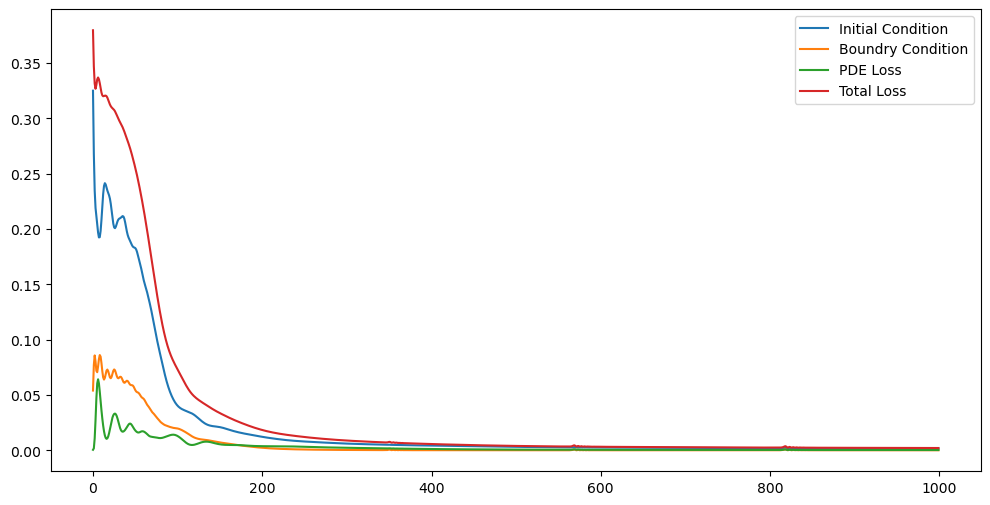

In [207]:
p.plot()

In [208]:
x, t, o = p.predict()

In [209]:
len(o)

1000

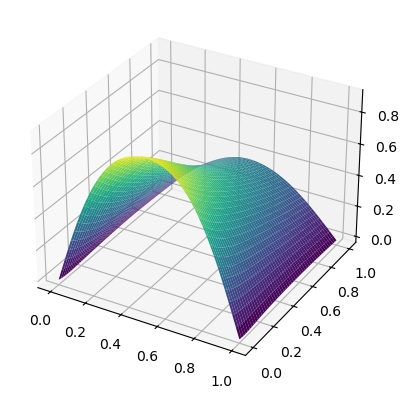

In [222]:
ax = plt.axes(projection= '3d')
ax.plot_surface(x, t, o, cmap = 'viridis')

In [ ]:
plt.show()

In [1]:
import sympy as sp


In [17]:
eqn = "sin(x)"

In [24]:
symbols = sp.symbols('x')
expr = sp.sympify(eqn)
func = sp.lambdify(symbols, expr, modules=['pytorch'])


NameError: 'pytorch' module cannot be used for lambdification

In [ ]:
print(func)

<function _lambdifygenerated at 0x7a040d5f79c0>
